# Training neural network with 3 hidden layer
### Import packages and get the data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import style
import util
import get_data, sklearn
import datetime as dt
import tensorflow as tf
%matplotlib inline

style.use('ggplot')

# Choose start/end date
start_date = '1950-1-3'
end_date = '2017-4-21'
dates = pd.date_range(start_date, end_date)

# Choose which stock to look at
stock = '^GSPC'

data = get_data.get_data_csv(stock, dates, redownload=True)
data.dropna(inplace=True)
data = util.remove_data_with_same_open_close(data)
data.head()

,Open,High,Low,Close,Volume,Adj Close
1962-01-02,71.550003,71.959999,70.709999,70.959999,3120000.0,70.959999
1962-01-03,70.959999,71.480003,70.379997,71.129997,3590000.0,71.129997
1962-01-04,71.129997,71.620003,70.449997,70.639999,4450000.0,70.639999
1962-01-05,70.639999,70.839996,69.349998,69.660004,4630000.0,69.660004
1962-01-08,69.660004,69.839996,68.169998,69.120003,4620000.0,69.120003


### Data Preprocessing

In [2]:
#calculate features
datanew = util.calc_features_new(data, look_back=120, fee=0)
datanew.dropna(inplace=True)
target = datanew['Change']
features = datanew.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Change'], axis=1)
from sklearn import preprocessing
features_scaled = pd.DataFrame(preprocessing.scale(features))

In [3]:
# time series split
from sklearn.model_selection import TimeSeriesSplit
n_splits = 15
tscv = TimeSeriesSplit(n_splits=n_splits)

In [4]:
# calculate target with one hot encoding
target = pd.DataFrame(target)
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()
one_hot.fit(target)
target_scaled = one_hot.transform(target).toarray()

### Parameter search for best accuracy for neural networks with 3 hidden layers

In [5]:
from NeuralNetwork_Cross_Entropy_mini_batch import NeuralNetwork
best_prediction = 0
accuracy_dict = {}

# h1n: number of neurons in the first hidden layer
# h2n: number of neurons in the second hidden layer
# h3n: number of neurons in the third hidden layer
# keep_prob: the keep probability for drop-out
# learning_rate: the learning rate for the gradient descent algorith

for h1n in [10, 20, 40]:
    for keep_prob in [0.5]:
        for learning_rate in [0.001, 0.0001]:
            h2n = int(h1n/2)
            h3n = int(h2n/2)
            print("learning_rate = " + str(learning_rate))
            print("#1st hidden_layer_size = " + str(h1n)\
                + ", #2nd hidden_layer_size = " + str(h2n)\
                + ", #3rd hidden_layer_size = " + str(h3n)\
                + ", keep_prob = " + str(keep_prob))
            index = 'learning_rate_'+str(learning_rate)+'_h1n_'+str(h1n)+'_h2n_'+str(h2n)\
                                    +'_h3n_'+str(h3n)+'_kp_'+str(keep_prob)
            i = 1
            accuracy_list = []
            for train_index, test_index in tscv.split(features_scaled):
                X_train, X_test = features_scaled.values[train_index], features_scaled.values[test_index]
                y_train, y_test = target_scaled[train_index], target_scaled[test_index]
                sess = tf.Session()
                
                # train and test neural network with 3 hidden layers
                nnmodel = NeuralNetwork(sess, X_train.shape[0], X_train.shape[1], n_nodes=[h1n,h2n,h3n],\
                                        learning_rate=learning_rate, training_epochs=3000)
                y_pred, cost_list, test_cost_list = nnmodel.train_and_test(X_train, y_train, X_test,\
                                                                           y_test, keep_prob)
                correct_prediction = np.equal(np.argmax(y_test,1), np.argmax(y_pred,1))
                accuracy_list.append(np.mean(correct_prediction.astype(np.float32)))
                
                # get the best model with largest average accuracy at the last split.
                if i == n_splits:
                    accuracy_dict[index] = np.mean(accuracy_list)
                    print('\ntest accuracy = ', accuracy_dict[index])
                    if accuracy_dict[index] > best_prediction:
                        best_prediction = accuracy_dict[index]
                        best_nn_estimator = nnmodel
                        best_pred = y_pred
                        save_test = y_test
                        save_test_index = test_index
                        saver = tf.train.Saver()
                        saver.save(sess, 'best_estimator.chk')
                sess.close()
                i += 1       


learning_rate = 0.001
#1st hidden_layer_size = 10, #2nd hidden_layer_size = 5, #3rd hidden_layer_size = 2, keep_prob = 0.5
epoch = 2900, cost = 0.668742, test_cost = 0.659432
test accuracy =  0.552648
learning_rate = 0.0001
#1st hidden_layer_size = 10, #2nd hidden_layer_size = 5, #3rd hidden_layer_size = 2, keep_prob = 0.5
epoch = 2900, cost = 0.674277, test_cost = 0.670660
test accuracy =  0.551869
learning_rate = 0.001
#1st hidden_layer_size = 20, #2nd hidden_layer_size = 10, #3rd hidden_layer_size = 5, keep_prob = 0.5
epoch = 2900, cost = 0.655261, test_cost = 0.657442
test accuracy =  0.552259
learning_rate = 0.0001
#1st hidden_layer_size = 20, #2nd hidden_layer_size = 10, #3rd hidden_layer_size = 5, keep_prob = 0.5
epoch = 2900, cost = 0.660772, test_cost = 0.658015
test accuracy =  0.55553
learning_rate = 0.001
#1st hidden_layer_size = 40, #2nd hidden_layer_size = 20, #3rd hidden_layer_size = 10, keep_prob = 0.5
epoch = 2900, cost = 0.633345, test_cost = 0.678854
test accuracy = 

In [8]:
max(accuracy_dict, key = accuracy_dict.get)

'learning_rate_0.0001_h1n_40_h2n_20_h3n_10_kp_0.5'

In [9]:
best_prediction

0.55638629

### Plot the ROI for the best model

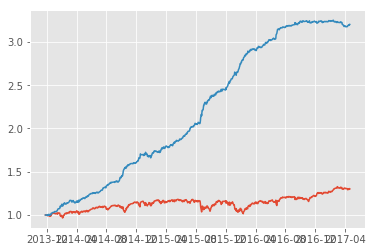

In [10]:
data_test = datanew.ix[save_test_index]
asset = np.zeros(len(data_test))
fee=5
nstock=100  # number of stocks to trade
price = data_test.ix[0]['Open'] * nstock
asset[0] = price
for i in range(len(data_test)):
    if best_pred[i][0] < best_pred[i][1]:
        #buy n stocks
        price += -data_test.ix[i]['Open'] * nstock + data_test.ix[i]['Close'] * nstock - fee
    else:
        #sell n stocks
        price += data_test.ix[i]['Open'] * nstock - data_test.ix[i]['Close'] * nstock - fee
    asset[i] = price
start_asset = data_test.ix[0]['Open'] * nstock  # start asset: the total price of stocks bought in the beginning
ref = start_asset + data_test['Close'] * nstock - data_test.ix[0]['Open']*nstock  # buy-hold reference
plt.plot(ref / start_asset)
plt.plot(pd.DataFrame(asset, index=data_test.index) / start_asset)

In [12]:
# return on investment (ROI)
asset[-1]/start_asset

3.2045700696504906